In [49]:
#importing required lirbraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [50]:
#uploading dataset files
books_df = pd.read_csv('Books.csv')
users_df = pd.read_csv('Users.csv', encoding='latin-1', on_bad_lines='skip')

ratings_df = pd.read_csv('Ratings.csv')

In [51]:
# preproessing  the rating data
#taking only important coloumns
ratings_df = ratings_df[ratings_df['User-ID'].notnull() & ratings_df['ISBN'].notnull()]
ratings_df = ratings_df[ratings_df['Book-Rating'] > 0]

# taking sample upto 5000 records to reduce size for testing
ratings_df = ratings_df.sample(n=100, random_state=22)


In [52]:
# creating  user item matric
#creating pivot table in this rows = users columns = books values = ratings
user_item_matrix = ratings_df.pivot_table(index='User-ID', columns='ISBN', values='Book-Rating').fillna(0)

# coverting into NumPy matrix
R = user_item_matrix.values
print(" User-Item Matrix shape:", R.shape)


 User-Item Matrix shape: (52, 100)


In [53]:
#matrix factorization
def initialize_factors(R, K):
    num_users, num_items = R.shape
    P = np.random.rand(num_users, K)
    Q = np.random.rand(num_items, K)
    return P, Q


In [54]:
#updating p and q suing gradintt decent
def update_factors(R, P, Q, K, alpha, beta):
    num_users, num_items = R.shape
    for i in range(num_users):
        for j in range(num_items):
            if R[i][j] > 0:
                eij = R[i][j] - np.dot(P[i], Q[j].T)
                for k in range(K):
                    P[i][k] += alpha * (2 * eij * Q[j][k] - beta * P[i][k])
                    Q[j][k] += alpha * (2 * eij * P[i][k] - beta * Q[j][k])
    return P, Q


In [55]:
#calculation of rmse
def calculate_rmse(R, P, Q):
    num_users, num_items = R.shape
    total_error = 0
    count = 0
    for i in range(num_users):
        for j in range(num_items):
            if R[i][j] > 0:
                total_error += (R[i][j] - np.dot(P[i], Q[j].T)) ** 2
                count += 1
    return np.sqrt(total_error / count)


In [56]:
# here is plotting graph
def plot_rmse(errors):
    plt.plot(range(1, len(errors)+1), errors, marker='o')
    plt.title("Training RMSE Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.grid(True)
    plt.show()



In [57]:
#training function
def matrix_factorization(R, K=10, steps=50, alpha=0.002, beta=0.02):
    P, Q = initialize_factors(R, K)
    errors = []

    for step in range(steps):
        P, Q = update_factors(R, P, Q, K, alpha, beta)
        rmse = calculate_rmse(R, P, Q)
        errors.append(rmse)
        print(f"Epoch {step+1}/{steps} - RMSE: {rmse:.4f}")

    plot_rmse(errors)
    return P, Q.T, errors


Epoch 1/10 - RMSE: 6.3752
Epoch 2/10 - RMSE: 6.2271
Epoch 3/10 - RMSE: 6.0735
Epoch 4/10 - RMSE: 5.9145
Epoch 5/10 - RMSE: 5.7505
Epoch 6/10 - RMSE: 5.5820
Epoch 7/10 - RMSE: 5.4098
Epoch 8/10 - RMSE: 5.2348
Epoch 9/10 - RMSE: 5.0580
Epoch 10/10 - RMSE: 4.8806


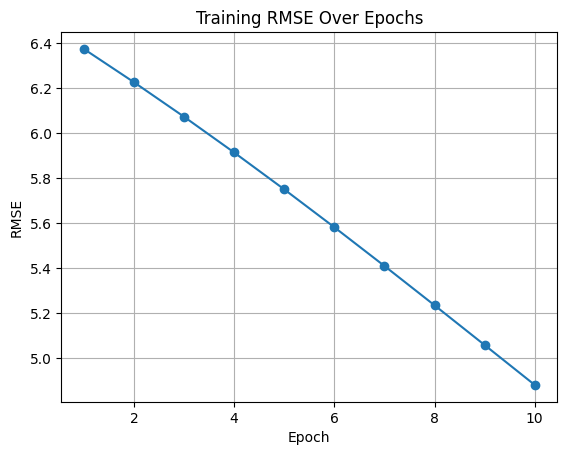

In [58]:
#traing the model
P, Q, errors = matrix_factorization(R, K=5, steps=10, alpha=0.002, beta=0.02)

In [59]:
#prediction of all ratings
predicted_ratings = np.dot(P, Q)

# coveeting predicted rating  to dataframe
predicted_df = pd.DataFrame(predicted_ratings,
                             index=user_item_matrix.index,
                            columns=user_item_matrix.columns)


In [60]:
#evaluting accuracy using rmse
def evaluate_rmse(predicted_df, ratings_df):
    actuals = []
    preds = []

    for row in ratings_df.itertuples():
        user = row._1
        book = row.ISBN
        rating = row._3

        try:
            pred = predicted_df.loc[user, book]
            actuals.append(rating)
            preds.append(pred)
        except:
            continue

    rmse = np.sqrt(mean_squared_error(actuals, preds))
    return rmse

rmse_score = evaluate_rmse(predicted_df, ratings_df)
print(f"\n Final RMSE: {rmse_score:.4f}")



 Final RMSE: 4.8806


In [61]:
#recommending top books to user
def recommend_books(predicted_df, ratings_df, user_id, num_recommendations=5):
    rated_books = ratings_df[ratings_df['User-ID'] == user_id]['ISBN'].tolist()
    user_predictions = predicted_df.loc[user_id]
    user_recommendations = user_predictions.drop(labels=rated_books, errors='ignore')
    top_books = user_recommendations.sort_values(ascending=False).head(num_recommendations)
    return top_books

In [62]:
print(recommended_output.columns)
# for checking coloum name

Index(['Book-ID', 'Predicted Rating', 'User-ID', 'ISBN', 'Book-Rating'], dtype='object')


In [63]:
#taking sample user
sample_user = predicted_df.index[0]
print("Sample user selected:", sample_user)


Sample user selected: 276729


In [64]:
#recommend tope books

top_books = recommend_books(predicted_df, ratings_df, user_id=sample_user, num_recommendations=5)
print("Top recommended ISBNs:\n", top_books)


Top recommended ISBNs:
 ISBN
0553285920    3.688928
3551551685    3.463662
0618045996    3.303230
2266102621    3.279951
3442441080    3.253407
Name: 276729, dtype: float64


In [65]:
   #Preparing the DataFrame
top_books_df = top_books.reset_index().rename(columns={top_books.name: 'Predicted Rating', 'ISBN': 'Book-ID'})
print(top_books_df)


      Book-ID  Predicted Rating
0  0553285920          3.688928
1  3551551685          3.463662
2  0618045996          3.303230
3  2266102621          3.279951
4  3442441080          3.253407


In [66]:
#  Merge  books_df to find book details
recommended_output = pd.merge(top_books_df, books_df, left_on='Book-ID', right_on='ISBN', how='left')


In [67]:
# finding book title column
print("Available columns after merge:", recommended_output.columns.tolist())

title_column = None
for col in recommended_output.columns:
    if 'title' in col.lower():
        title_column = col
        break

if title_column:
    recommended_output = recommended_output[['Book-ID', title_column, 'Predicted Rating']]
    recommended_output.columns = ['Book ID', 'Book Title', 'Predicted Rating']
else:
    print(" Book title column not found in merged data.")


Available columns after merge: ['Book-ID', 'Predicted Rating', 'User-ID', 'ISBN', 'Book-Rating']
 Book title column not found in merged data.


In [71]:
# saving final output


# showing the output
print("\n Top Book Recommendations:\n")
print(recommended_output)

# saving to CSV file
filename = f"Recommended_Books_User_{sample_user}.csv"
recommended_output.to_csv(filename, index=False)

print(f"\n File saved as: {filename}")



 Top Book Recommendations:

      Book-ID  Predicted Rating  User-ID        ISBN  Book-Rating
0  0553285920          3.688928   277170  0553285920            9
1  3551551685          3.463662   276847  3551551685           10
2  0618045996          3.303230   276998  0618045996            8
3  2266102621          3.279951   276929  2266102621           10
4  3442441080          3.253407   276847  3442441080           10

 File saved as: Recommended_Books_User_276729.csv
